In [1]:
%cd ..

/home/marco/contrast-gan-3D


In [2]:
from pathlib import Path

from contrast_gan_3D.config import CHECKPOINTS_DIR
from contrast_gan_3D.eval.CCTAContrastCorrector import CCTAContrastCorrector
from contrast_gan_3D.experiments.basic_conf import (
    generator_class,
    scaler,
    train_patch_size,
)
from contrast_gan_3D.utils import set_GPU

test_folder = Path("/home/marco/data/test_inference")
test_folder.mkdir(exist_ok=True)

p = Path("/home/marco/data/MMWHS/ct_test/ct_test_2027_image.h5")
print(p)

model_checkpoint_3D = CHECKPOINTS_DIR / "blwlllmf" / "7000.pt"
model_checkpoint_2D = CHECKPOINTS_DIR / "g5gqrbqo" / "10000.pt"
print(model_checkpoint_3D, model_checkpoint_3D.is_file())
print(model_checkpoint_2D, model_checkpoint_2D.is_file())

device = set_GPU(3)

/home/marco/data/MMWHS/ct_test/ct_test_2027_image.h5
/home/marco/contrast-gan-3D/logs/model_checkpoints/blwlllmf/7000.pt True
/home/marco/contrast-gan-3D/logs/model_checkpoints/g5gqrbqo/10000.pt True


In [3]:
inference_patch_size = train_patch_size
# inference_patch_size = (100, 100, 101)
# inference_patch_size = None
# checkpoint_path = model_checkpoint_2D
checkpoint_path = model_checkpoint_3D

corrector = CCTAContrastCorrector(
    generator_class,
    scaler,
    device,
    inference_patch_size=inference_patch_size,
    checkpoint_path=checkpoint_path,
)
corrector

[2024-04-30 11:33:22,430: INFO] Loaded model checkpoint '/home/marco/contrast-gan-3D/logs/model_checkpoints/blwlllmf/7000.pt' (contrast_gan_3D.eval.CCTAContrastCorrector:57)


CCTAContrastCorrector(model=ResnetGenerator(
  (model): Sequential(
    (first): ConvBlock(
      (conv): Conv3d(1, 16, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False, padding_mode=reflect)
      (normalization): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_fn): ReLU(inplace=True)
    )
    (downsampling): Sequential(
      (0): ConvBlock(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (normalization): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_fn): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (normalization): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_fn): ReLU(inplace=True)
      )
    )
    (resnet_backbone): Sequential

In [4]:
from contrast_gan_3D.data.HD5Scan import HD5Scan

with HD5Scan(p) as scan:
    corrected = corrector(scan.ccta[::])
    centerlines = corrected[scan.labelmap[::].astype(bool)]
    # corrector.save_scan(
    #     corrected,
    #     scan.meta["offset"],
    #     scan.meta["spacing"],
    #     test_folder / f"{p.stem}.mhd",
    # )
print(corrected.shape, centerlines.shape)

/home/marco/micromamba/envs/contrast-gan-3D/lib/python3.11/site-packages/patchly/array_like.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([512, 512, 239]) torch.Size([4373])


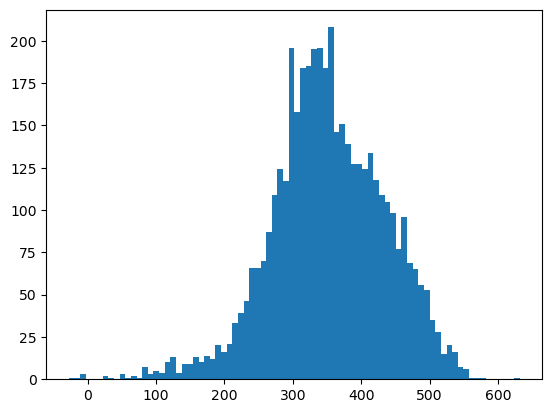

In [5]:
from matplotlib import pyplot as plt


plt.hist(centerlines, bins=80);